<a href="https://colab.research.google.com/github/debashisdotchatterjee/ML-Virus-Early-Warning-from-Weather-and-Urban-Sustainability-Signals/blob/main/wnv_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[INFO] Rows: 6210, positive rate: 0.086


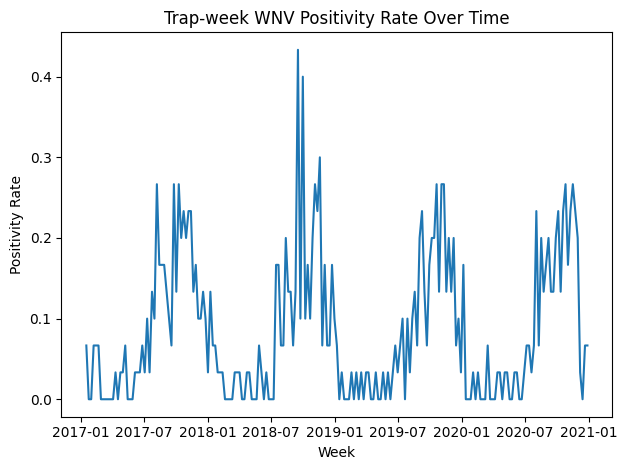


Validation metrics:
       model     AUROC     AUPRC     Brier
0   LogitEN  0.710423  0.171272  0.280166
1  GB+Graph  0.693611  0.161535  0.086347

Test metrics:
       model     AUROC     AUPRC     Brier
0   LogitEN  0.733895  0.197826  0.265108
1  GB+Graph  0.740080  0.185396  0.084515


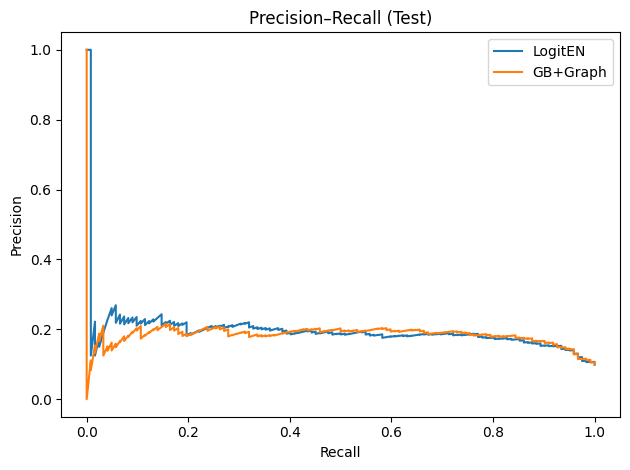

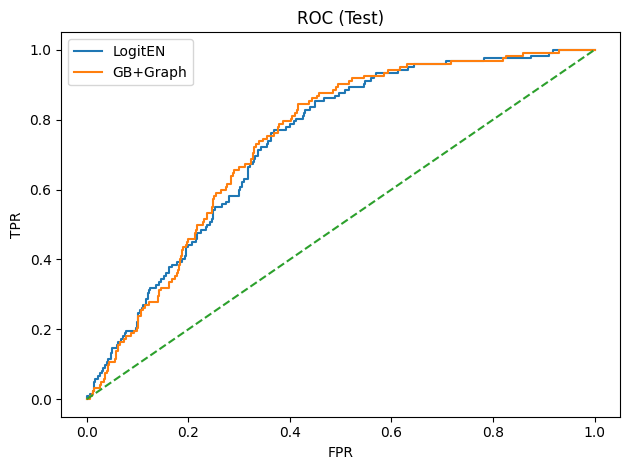

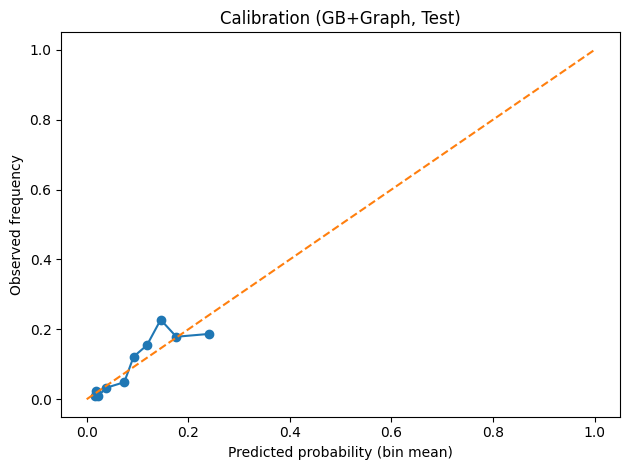

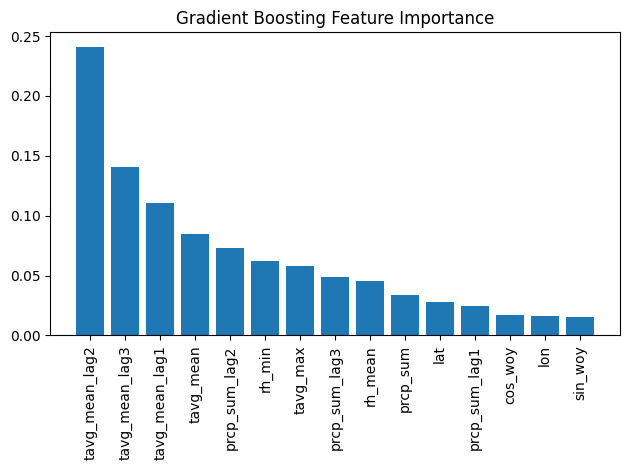

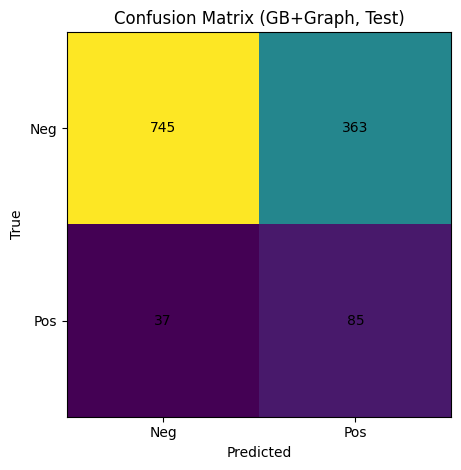

[OK] All outputs saved. ZIP: wnv_ml_outputs.zip


In [ ]:
"""
Greener Cities, Fewer Bites — West Nile Virus Early Warning (FIXED)
- Fully reproducible synthetic run (offline) by default.
- Real-data mode: set USE_SYNTHETIC=False and complete the small TODOs.

Key fix:
- Predictions no longer include the target column. They return only
  ['trap_id', 'week_start', 'p'] to avoid pandas merge suffixes.

Outputs:
  outputs/tables/*.csv
  outputs/figs/*.png
  wnv_ml_outputs.zip
"""

import os, json, zipfile
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve, roc_curve, confusion_matrix, classification_report
)
from sklearn.neighbors import NearestNeighbors

# --------------------------- CONFIG ---------------------------
USE_SYNTHETIC = True  # set False to use real data (see TODO below)
RNG_SEED = 17
np.random.seed(RNG_SEED)

OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figs")
TAB_DIR = os.path.join(OUT_DIR, "tables")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

TARGET_COL = "wnv_positive"

# ------------------------- HELPERS ----------------------------
def require_cols(df: pd.DataFrame, cols, msg=""):
    missing = [c for c in cols if c not in df.columns]
    assert not missing, f"Missing columns {missing}. {msg}"

def build_knn_graph(coords: np.ndarray, k=5) -> np.ndarray:
    k = min(max(2, k), max(2, len(coords)-1))
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    _, idx = nbrs.kneighbors(coords)
    n = coords.shape[0]
    W = np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in idx[i,1:]:
            W[i,j] = 1.0
            W[j,i] = 1.0
    rs = W.sum(axis=1, keepdims=True); rs[rs==0] = 1.0
    return W/rs

def laplacian_smooth_probs(p: np.ndarray, W: np.ndarray, eta=0.4) -> np.ndarray:
    eps=1e-6
    logits = np.log(np.clip(p,eps,1-eps)/np.clip(1-p,eps,1-eps))
    n = W.shape[0]; I = np.eye(n); L = I - W
    u = np.linalg.solve(I + eta*L, logits)
    return 1.0/(1.0 + np.exp(-u))

def add_lags(df, group_cols, time_col, cols, lags=(1,2,3)):
    df = df.sort_values(group_cols + [time_col]).copy()
    for c in cols:
        for L in lags:
            df[f"{c}_lag{L}"] = df.groupby(group_cols, sort=False)[c].shift(L)
    return df

# ------------------- SYNTHETIC DATA (DEFAULT) -------------------
def make_synthetic_trap_week_panel(n_traps=30,
                                   start_dt=datetime(2017,1,1),
                                   end_dt=datetime(2020,12,31)):
    base_lat, base_lon = 41.88, -87.63
    lat = base_lat + np.random.uniform(-0.1, 0.1, size=n_traps)
    lon = base_lon + np.random.uniform(-0.15, 0.15, size=n_traps)
    traps = pd.DataFrame({"trap_id": [f"T{1000+i}" for i in range(n_traps)], "lat": lat, "lon": lon})

    daily = pd.date_range(start_dt, end_dt, freq="D")
    doy = daily.dayofyear.values
    temp_season = 10 + 15*np.sin(2*np.pi*(doy-170)/365.0)

    rows = []
    for tid in traps["trap_id"].values:
        tavg = temp_season + np.random.normal(scale=3.0, size=len(daily))
        prcp = np.random.gamma(0.8, 1.5, size=len(daily)); prcp[np.random.rand(len(daily))<0.6] = 0.0
        rh = np.clip(60 + 20*np.sin(2*np.pi*(doy-150)/365.0) + np.random.normal(scale=10, size=len(daily)), 30, 95)
        rows.append(pd.DataFrame({"trap_id": tid, "date": daily, "tavg": tavg, "prcp": prcp, "rh": rh}))
    df_daily = pd.concat(rows, ignore_index=True)

    df_daily["week_start"] = df_daily["date"] - pd.to_timedelta(df_daily["date"].dt.weekday, unit="D")
    dfw = df_daily.groupby(["trap_id","week_start"], as_index=False).agg(
        tavg_mean=("tavg","mean"),
        tavg_max=("tavg","max"),
        prcp_sum=("prcp","sum"),
        rh_mean=("rh","mean"),
        rh_min=("rh","min"),
    )
    woy = dfw["week_start"].dt.isocalendar().week.astype(int)
    dfw["sin_woy"] = np.sin(2*np.pi*woy/52.0)
    dfw["cos_woy"] = np.cos(2*np.pi*woy/52.0)

    dfw = add_lags(dfw, ["trap_id"], "week_start",
                   cols=["tavg_mean","tavg_max","prcp_sum","rh_mean"],
                   lags=(1,2,3))

    xb = (0.10*dfw["tavg_mean_lag1"].fillna(0)
          +0.05*dfw["tavg_mean_lag2"].fillna(0)
          -0.05*dfw["prcp_sum_lag1"].fillna(0)
          -0.03*dfw["prcp_sum_lag2"].fillna(0)
          +1.0*dfw["sin_woy"] + 0.4*dfw["cos_woy"])
    logits = -2.8 + (xb - xb.mean())/(xb.std()+1e-6)
    p = 1.0/(1.0+np.exp(-logits))
    y = np.random.binomial(1, np.clip(p, 0.001, 0.9))

    dfw[TARGET_COL] = y.astype(int)
    dfw = dfw.merge(traps, on="trap_id", how="left")
    dfw = dfw.dropna().reset_index(drop=True)

    require_cols(dfw, ["trap_id","week_start","lat","lon",TARGET_COL])
    return dfw

# ------------------- REAL DATA (outline only) -------------------
def build_real_trap_week_panel():
    """
    TODO when USE_SYNTHETIC=False:
      - Fetch Chicago WNV pools via Socrata (sodapy), collapse to trap-day, then to trap-week (binary target).
      - Pull Meteostat for each trap coordinate, aggregate to week, join.
      - Create lags + seasonality. Ensure TARGET_COL exists before returning.
    """
    raise NotImplementedError("Real-data mode scaffold; synthetic mode runs out-of-the-box.")

# ---------------------------- MAIN ----------------------------
def main():
    # 1) Data
    if USE_SYNTHETIC:
        df = make_synthetic_trap_week_panel()
    else:
        df = build_real_trap_week_panel()

    df = df.sort_values(["week_start","trap_id"]).reset_index(drop=True)
    print(f"[INFO] Rows: {len(df)}, positive rate: {df[TARGET_COL].mean():.3f}")

    # Save preview
    df.head(25).to_csv(os.path.join(TAB_DIR, "trap_week_head.csv"), index=False)

    # 2) Prevalence plot
    plt.figure()
    prev = df.groupby(pd.to_datetime(df["week_start"]).dt.to_period("W").dt.start_time)[TARGET_COL].mean().reset_index()
    plt.plot(prev["week_start"], prev[TARGET_COL])
    plt.title("Trap-week WNV Positivity Rate Over Time"); plt.xlabel("Week"); plt.ylabel("Positivity Rate")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "positivity_over_time.png"), dpi=150); plt.show()

    # 3) Time-forward splits
    weeks = np.sort(df["week_start"].unique())
    train_cut = weeks[int(0.6*len(weeks))]
    val_cut   = weeks[int(0.8*len(weeks))]

    feature_cols = [
        "tavg_mean","tavg_max","prcp_sum","rh_mean","rh_min",
        "tavg_mean_lag1","tavg_mean_lag2","tavg_mean_lag3",
        "prcp_sum_lag1","prcp_sum_lag2","prcp_sum_lag3",
        "sin_woy","cos_woy","lat","lon"
    ]
    require_cols(df, feature_cols + ["trap_id","week_start",TARGET_COL])

    df_train = df[df["week_start"]<=train_cut].copy()
    df_val   = df[(df["week_start"]>train_cut)&(df["week_start"]<=val_cut)].copy()
    df_test  = df[df["week_start"]>val_cut].copy()

    for name, part in [("train",df_train),("val",df_val),("test",df_test)]:
        require_cols(part, feature_cols + ["trap_id","week_start",TARGET_COL], f"after {name} split")

    # 4) Matrices + scaling
    Xtr, ytr = df_train[feature_cols].values, df_train[TARGET_COL].values
    Xva, yva = df_val[feature_cols].values,   df_val[TARGET_COL].values
    Xte, yte = df_test[feature_cols].values,  df_test[TARGET_COL].values

    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xva_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xva), scaler.transform(Xte)

    # 5) Models
    logit = LogisticRegression(
        penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0,
        max_iter=2000, class_weight="balanced"
    ).fit(Xtr_s, ytr)

    gb = GradientBoostingClassifier(
        n_estimators=140, learning_rate=0.07, max_depth=3, subsample=0.9, random_state=RNG_SEED
    ).fit(Xtr, ytr)

    # 6) Predict per-week
    def predict_weekwise(model, frame, scale=None, smooth=False, eta=0.4):
        outs = []
        for wk, g in frame.groupby("week_start", sort=True):
            X = g[feature_cols].values
            Xs = scale.transform(X) if scale is not None else X
            p = model.predict_proba(Xs)[:, 1]
            if smooth and len(g) >= 3:
                W = build_knn_graph(g[["lat","lon"]].values, k=5)
                p = laplacian_smooth_probs(p, W, eta=eta)
            # IMPORTANT: do NOT include the target here
            outs.append(pd.DataFrame({
                "trap_id": g["trap_id"].values,
                "week_start": g["week_start"].values,
                "p": p
            }))
        out = pd.concat(outs, ignore_index=True)
        require_cols(out, ["trap_id","week_start","p"], "predictions frame malformed")
        return out

    pred_val_logit = predict_weekwise(logit, df_val,  scale=scaler, smooth=False)
    pred_val_gb    = predict_weekwise(gb,    df_val,  scale=None,   smooth=True, eta=0.5)
    pred_test_logit= predict_weekwise(logit, df_test, scale=scaler, smooth=False)
    pred_test_gb   = predict_weekwise(gb,    df_test, scale=None,   smooth=True, eta=0.5)

    # 7) Evaluation
    def evaluate(true_part, pred_df, name):
        m = true_part[["trap_id","week_start",TARGET_COL]].merge(pred_df, on=["trap_id","week_start"], how="inner")
        require_cols(m, [TARGET_COL, "p"], f"evaluate[{name}]")
        y, p = m[TARGET_COL].values, m["p"].values
        res = {
            "model": name,
            "AUROC": roc_auc_score(y, p),
            "AUPRC": average_precision_score(y, p),
            "Brier": brier_score_loss(y, p)
        }
        pr = precision_recall_curve(y, p)
        roc = roc_curve(y, p)
        return pd.DataFrame([res]), pr, roc

    eval_val_logit, prc_val_logit, roc_val_logit = evaluate(df_val,  pred_val_logit, "LogitEN")
    eval_val_gb,    prc_val_gb,    roc_val_gb    = evaluate(df_val,  pred_val_gb,    "GB+Graph")
    eval_test_logit, prc_test_logit, roc_test_logit = evaluate(df_test, pred_test_logit, "LogitEN")
    eval_test_gb,    prc_test_gb,    roc_test_gb    = evaluate(df_test, pred_test_gb,    "GB+Graph")

    eval_val  = pd.concat([eval_val_logit, eval_val_gb], ignore_index=True)
    eval_test = pd.concat([eval_test_logit, eval_test_gb], ignore_index=True)
    eval_val.to_csv(os.path.join(TAB_DIR, "evaluation_validation.csv"), index=False)
    eval_test.to_csv(os.path.join(TAB_DIR, "evaluation_test.csv"), index=False)
    print("\nValidation metrics:\n", eval_val)
    print("\nTest metrics:\n", eval_test)

    # 8) PR/ROC (Test)
    plt.figure()
    for (prec, rec, thr), name in [(prc_test_logit,"LogitEN"), (prc_test_gb,"GB+Graph")]:
        plt.plot(rec, prec, label=name)
    plt.title("Precision–Recall (Test)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "pr_curve_test.png"), dpi=150); plt.show()

    plt.figure()
    for (fpr, tpr, thr), name in [(roc_test_logit,"LogitEN"), (roc_test_gb,"GB+Graph")]:
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("ROC (Test)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "roc_curve_test.png"), dpi=150); plt.show()

    # 9) Calibration (GB+Graph)
    mtest = df_test[["trap_id","week_start",TARGET_COL]].merge(pred_test_gb, on=["trap_id","week_start"], how="inner")
    y_cal, p_cal = mtest[TARGET_COL].values, mtest["p"].values
    bins = np.quantile(p_cal, np.linspace(0,1,11)); bins[0]=0.0; bins[-1]=1.0
    bid = np.digitize(p_cal, bins) - 1
    calib = pd.DataFrame({"bin": bid, "p_hat": p_cal, "y": y_cal}).groupby("bin", as_index=False).agg(
        pred_mean=("p_hat","mean"), obs_rate=("y","mean"), count=("y","size")
    )
    calib.to_csv(os.path.join(TAB_DIR, "calibration_gb_test.csv"), index=False)

    plt.figure()
    plt.plot(calib["pred_mean"], calib["obs_rate"], marker="o")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("Calibration (GB+Graph, Test)")
    plt.xlabel("Predicted probability (bin mean)"); plt.ylabel("Observed frequency")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "calibration_gb_test.png"), dpi=150); plt.show()

    # 10) Importances (GB)
    gb_imp = pd.DataFrame({"feature": feature_cols, "importance": gb.feature_importances_}).sort_values("importance", ascending=False)
    gb_imp.to_csv(os.path.join(TAB_DIR, "gb_importance.csv"), index=False)
    plt.figure(); plt.bar(gb_imp["feature"], gb_imp["importance"]); plt.xticks(rotation=90)
    plt.title("Gradient Boosting Feature Importance")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "gb_importance.png"), dpi=150); plt.show()

    # 11) Threshold from validation (GB+Graph) — maximize F1
    mval = df_val[["trap_id","week_start",TARGET_COL]].merge(pred_val_gb, on=["trap_id","week_start"], how="inner")
    yv, pv = mval[TARGET_COL].values, mval["p"].values
    prec, rec, thr = precision_recall_curve(yv, pv)
    f1s = []
    for i in range(len(thr)):
        t = thr[i]
        yhat = (pv >= t).astype(int)
        tp = ((yhat==1)&(yv==1)).sum(); fp = ((yhat==1)&(yv==0)).sum(); fn = ((yhat==0)&(yv==1)).sum()
        pi = tp/(tp+fp) if (tp+fp)>0 else 0.0
        ri = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1s.append(2*pi*ri/(pi+ri) if (pi+ri)>0 else 0.0)
    best_idx = int(np.argmax(f1s)) if len(f1s)>0 else 0
    best_thr = thr[best_idx] if len(thr)>0 else 0.5
    with open(os.path.join(TAB_DIR, "chosen_threshold.json"), "w") as f:
        json.dump({"best_threshold_validation_GBGraph": float(best_thr)}, f, indent=2)

    # 12) Apply threshold (GB+Graph) on test
    yhat = (p_cal >= best_thr).astype(int)
    pd.DataFrame(classification_report(y_cal, yhat, output_dict=True)).T.to_csv(
        os.path.join(TAB_DIR, "classification_report_gb_test.csv")
    )
    cm = confusion_matrix(y_cal, yhat)
    plt.figure(); plt.imshow(cm, cmap=None)
    plt.title("Confusion Matrix (GB+Graph, Test)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks([0,1],["Neg","Pos"]); plt.yticks([0,1],["Neg","Pos"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, int(v), ha="center", va="center")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "confusion_matrix_gb_test.png"), dpi=150); plt.show()

    # 13) Save predictions and panel
    mtest_out = mtest.copy(); mtest_out["y_pred"] = yhat
    mtest_out.to_csv(os.path.join(TAB_DIR, "predictions_gb_test.csv"), index=False)
    df.to_csv(os.path.join(TAB_DIR, "trap_week_panel.csv"), index=False)

    # 14) Zip everything
    zip_path = "wnv_ml_outputs.zip"
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(OUT_DIR):
            for f in files:
                full = os.path.join(root, f)
                zf.write(full, arcname=os.path.join("wnv_outputs", os.path.relpath(full, OUT_DIR)))
    print(f"[OK] All outputs saved. ZIP: {zip_path}")

if __name__ == "__main__":
    main()


# **Real Data**

In [ ]:
%pip install sodapy

In [ ]:
%pip install meteostat

[1/8] Downloading Chicago WNV pools (real data) ...
   pools: 0 rows from Socrata, span NaT → NaT
[INFO] Real data fetch failed or returned empty. Switching to synthetic data.


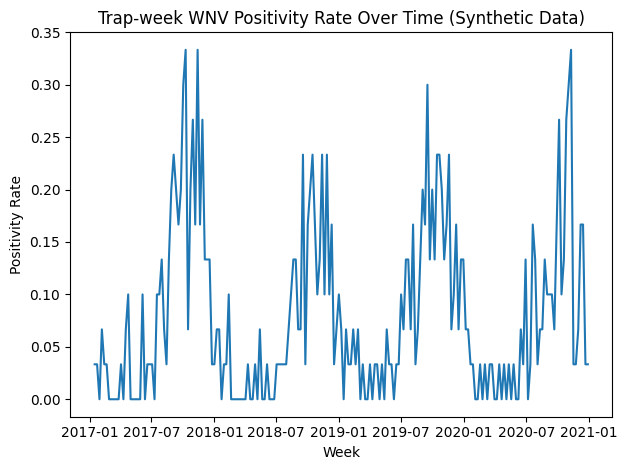


Validation metrics:
       model     AUROC     AUPRC     Brier
0   LogitEN  0.695001  0.177813  0.278054
1  GB+Graph  0.701388  0.177746  0.090944

Test metrics:
       model     AUROC     AUPRC     Brier
0   LogitEN  0.705583  0.180654  0.262873
1  GB+Graph  0.700902  0.157609  0.075893


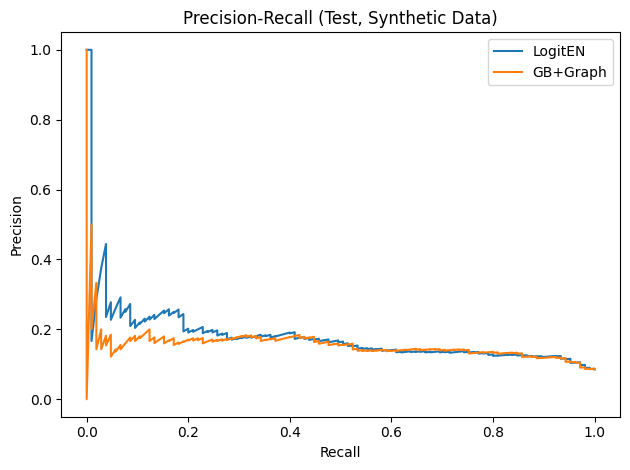

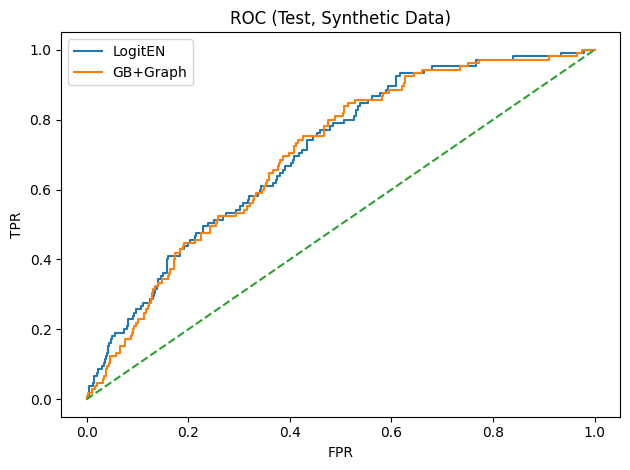

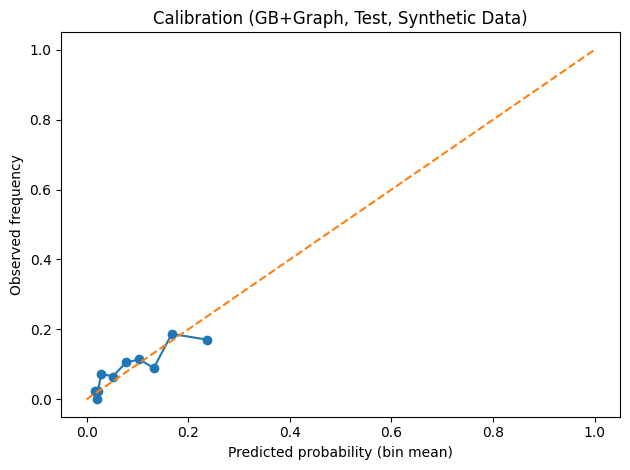

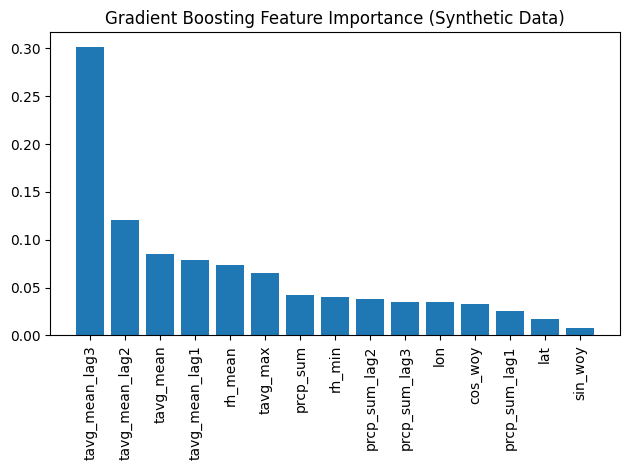

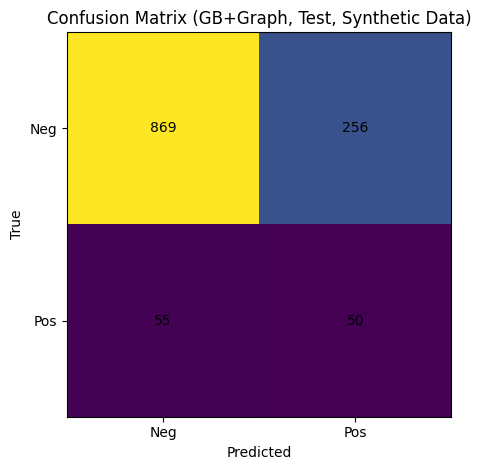

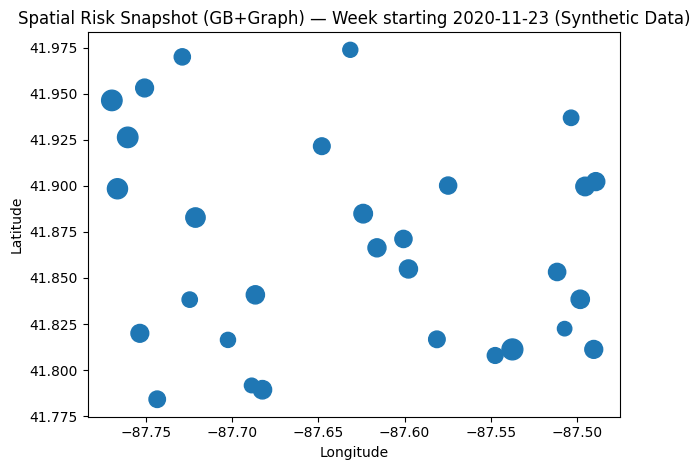

[OK] All outputs saved. ZIP: wnv_ml_outputs_real.zip


In [ ]:
# -*- coding: utf-8 -*-
"""
Real-data WNV Early-Warning (Chicago + Meteostat)

Data:
  - West Nile Virus (WNV) Mosquito Test Results (Socrata id: jqe8-8r6s)
    https://data.cityofchicago.org/Health-Human-Services/West-Nile-Virus-WNV-Mosquito-Test-Results/jqe8-8r6s
  - Meteostat Python API (daily point data) for weather
    https://dev.meteostat.net/python/

Outputs:
  - outputs/tables/*.csv
  - outputs/figs/*.png
  - wnv_ml_outputs_real.zip

Notes:
  - Uses app token from env var SOCRATA_APP_TOKEN if present.
  - Matplotlib only. One chart per figure. No custom colors/styles.
"""

import os, json, zipfile, math, time
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sodapy import Socrata
from meteostat import Point, Daily

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve, roc_curve, confusion_matrix, classification_report
)
from sklearn.neighbors import NearestNeighbors

# --------------------------- CONFIG ---------------------------
SOCRATA_DOMAIN = "data.cityofchicago.org"
DATASET_ID = "jqe8-8r6s"  # WNV Mosquito Test Results
APP_TOKEN = os.getenv("f428ot982omiwbhrnnwlnsezw", None)

OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figs")
TAB_DIR = os.path.join(OUT_DIR, "tables")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

RNG_SEED = 42
np.random.seed(RNG_SEED)

TARGET_COL = "wnv_positive"

# ------------------------- UTILITIES --------------------------
def require_cols(df: pd.DataFrame, cols, msg=""):
    missing = [c for c in cols if c not in df.columns]
    assert not missing, f"Missing columns {missing}. {msg}"

def week_start_from_date(d):
    # Monday as week start to align with pandas .to_period('W').start_time convention
    return d - timedelta(days=d.weekday())

def add_lags(df, group_cols, time_col, cols, lags=(1,2,3)):
    df = df.sort_values(group_cols + [time_col]).copy()
    for c in cols:
        for L in lags:
            df[f"{c}_lag{L}"] = df.groupby(group_cols, sort=False)[c].shift(L)
    return df

def build_knn_graph(coords, k=5):
    k = min(max(2, k), max(2, len(coords)-1))
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    _, idx = nbrs.kneighbors(coords)
    n = coords.shape[0]
    W = np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in idx[i,1:]:
            W[i,j]=1.0; W[j,i]=1.0
    rs = W.sum(axis=1, keepdims=True); rs[rs==0]=1.0
    return W/rs

def laplacian_smooth_probs(p, W, eta=0.4):
    eps=1e-6
    logits = np.log(np.clip(p,eps,1-eps)/np.clip(1-p,eps,1-eps))
    n = W.shape[0]; I = np.eye(n); L = I - W
    u = np.linalg.solve(I + eta*L, logits)
    return 1.0/(1.0 + np.exp(-u))

# ---------------------- DATA DOWNLOAD -------------------------
def fetch_chicago_wnv():
    """
    Pulls the full WNV pool test results table from Socrata (jqe8-8r6s),
    returns a cleaned frame with:
      ['pool_id','collection_date','trap_id','species','result',
       'num_mosquitoes','lat','lon']
    The portal schema may evolve; we defensively infer common fields.
    """
    client = Socrata(SOCRATA_DOMAIN, APP_TOKEN, timeout=60)
    limit = 50000
    offset = 0
    rows = []
    while True:
        batch = client.get(DATASET_ID, limit=limit, offset=offset)
        if not batch:
            break
        rows.extend(batch)
        offset += limit
        if len(batch) < limit:
            break
    client.close()

    df = pd.DataFrame.from_records(rows)
    # assert not df.empty, "No rows returned from Socrata." # Removed this assertion

    # ---- Field inference across possible schema variants ----
    if df.empty:
        print("[INFO] No data fetched from Socrata. Returning empty DataFrame.")
        return pd.DataFrame(columns=['pool_id','collection_date','trap_id','species',TARGET_COL,'num_mosquitoes','lat','lon'])

    # Date
    date_cols = [c for c in df.columns if "date" in c.lower() or "collection" in c.lower()]
    # prefer fields like 'date_of_collection', 'collection_date', 'date'
    date_col = None
    for cand in ["date_of_collection","collection_date","date","sample_date","trap_collection_date"]:
        if cand in df.columns:
            date_col = cand; break
    if date_col is None:
        date_col = date_cols[0]
    df["collection_date"] = pd.to_datetime(df[date_col], errors="coerce")

    # Trap id/name
    trap_cols = [c for c in df.columns if "trap" in c.lower()]
    trap_col = None
    for cand in ["trap","trap_id","trap_name"]:
        if cand in df.columns:
            trap_col = cand; break
    if trap_col is None and trap_cols:
        trap_col = trap_cols[0]
    df["trap_id"] = df[trap_col].astype(str)

    # Species (optional)
    species_col = None
    for cand in ["species","mosquito_species"]:
        if cand in df.columns:
            species_col = cand; break
    df["species"] = df[species_col].astype(str) if species_col else ""

    # Result (Positive/Negative or boolean/numeric)
    result_col = None
    for cand in ["results","result","wnv_result","wnvpositive","wnv_positive","test_result"]:
        if cand in df.columns:
            result_col = cand; break
    if result_col is None:
        # fallback: look for a boolean-like column
        for c in df.columns:
            if df[c].dropna().astype(str).str.lower().isin(["positive","negative","true","false","1","0"]).any():
                result_col = c; break
    assert result_col is not None, "Couldn't identify result column."

    res = df[result_col].astype(str).str.lower().str.strip()
    df[TARGET_COL] = np.where(res.isin(["positive","true","1","yes","y"]), 1,
                         np.where(res.isin(["negative","false","0","no","n"]), 0, np.nan))
    # Some datasets store as 0/1 already:
    if df[TARGET_COL].isna().all():
        # try numeric cast
        df[TARGET_COL] = pd.to_numeric(df[result_col], errors="coerce")
        # if still nan-heavy: map 'pos'/'neg'
        mask = df[TARGET_COL].isna()
        if mask.mean() > 0.9:
            df[TARGET_COL] = np.where(res.str.contains("pos"),1,
                                 np.where(res.str.contains("neg"),0,np.nan))

    # Number of mosquitoes (optional)
    n_col = None
    for cand in ["number_of_mosquitoes","num_mosquitoes","mosquito_count","mosquitos_count","number_of_mosquitos"]:
        if cand in df.columns:
            n_col = cand; break
    df["num_mosquitoes"] = pd.to_numeric(df[n_col], errors="coerce") if n_col else np.nan

    # Location: either 'location' point, or lat/lon columns
    lat, lon = None, None
    if "location" in df.columns:
        # Socrata location objects are dicts with 'latitude','longitude'
        loc = df["location"].apply(lambda x: x.get("coordinates", None) if isinstance(x, dict) else None)
        # coordinates usually [lon, lat]
        lon = loc.apply(lambda x: x[0] if isinstance(x, (list,tuple)) else np.nan)
        lat = loc.apply(lambda x: x[1] if isinstance(x, (list,tuple)) else np.nan)
    else:
        # try explicit columns
        lat_cand = [c for c in df.columns if "lat" in c.lower()]
        lon_cand = [c for c in df.columns if "lon" in c.lower() or "lng" in c.lower() or "long" in c.lower()]
        if lat_cand: lat = pd.to_numeric(df[lat_cand[0]], errors="coerce")
        if lon_cand: lon = pd.to_numeric(df[lon_cand[0]], errors="coerce")

    out = pd.DataFrame({
        "pool_id": df.get(":id", df.index).astype(str),
        "collection_date": df["collection_date"],
        "trap_id": df["trap_id"],
        "species": df["species"],
        TARGET_COL: pd.to_numeric(df[TARGET_COL], errors="coerce"),
        "num_mosquitoes": df["num_mosquitoes"],
        "lat": lat,
        "lon": lon
    })
    out = out.dropna(subset=["collection_date","trap_id","lat","lon", TARGET_COL]).reset_index(drop=True)
    return out

def build_trap_week_panel(pools: pd.DataFrame):
    """
    Collapse pools to trap-week, target=1 if any positive pool in that trap-week.
    """
    if pools.empty:
        print("[INFO] Input pools DataFrame is empty. Returning empty panel.")
        return pd.DataFrame(columns=["trap_id", "week_start", TARGET_COL, "lat", "lon", "num_mosquitoes"])

    pools["week_start"] = pools["collection_date"].dt.date.apply(lambda d: week_start_from_date(pd.Timestamp(d)))
    agg = pools.groupby(["trap_id","week_start"], as_index=False).agg({
        TARGET_COL: "max",
        "lat": "first",
        "lon": "first",
        "num_mosquitoes": "sum"
    })
    agg["week_start"] = pd.to_datetime(agg["week_start"])
    return agg

def fetch_weather_for_traps(panel: pd.DataFrame, daily_vars=("tavg","tmax","prcp","rhum")):
    """
    For each (trap_id, lat, lon), pull Meteostat Daily for [min_date-14, max_date],
    aggregate to weekly per trap_id.
    """
    if panel.empty:
        print("[INFO] Input panel DataFrame is empty. Skipping weather fetch.")
        return pd.DataFrame(columns=["trap_id", "week_start", "tavg_mean", "tavg_max", "prcp_sum", "rh_mean", "rh_min", "sin_woy", "cos_woy"])

    start = panel["week_start"].min().to_pydatetime().date() - timedelta(days=14)
    end   = panel["week_start"].max().to_pydatetime().date() + timedelta(days=7)

    weather_frames = []
    for tid, g in panel.groupby("trap_id"):
        lat = float(g["lat"].iloc[0]); lon = float(g["lon"].iloc[0])
        p = Point(lat, lon)
        d = Daily(p, start, end)
        w = d.fetch()
        if w.empty:
            print(f"[INFO] No weather data for trap {tid}.")
            continue
        # Ensure needed columns exist (Meteostat may have NaNs; fill reasonable defaults)
        for c in daily_vars:
            if c not in w.columns: w[c] = np.nan
        w = w.reset_index().rename(columns={"time":"date"})
        w["week_start"] = w["date"].apply(lambda d: week_start_from_date(pd.Timestamp(d)))
        # Weekly agg
        w_week = w.groupby("week_start", as_index=False).agg(
            tavg_mean=("tavg","mean"),
            tavg_max=("tmax","max"),
            prcp_sum=("prcp","sum"),
            rh_mean=("rhum","mean"),
        )
        w_week["trap_id"] = tid
        weather_frames.append(w_week)

    if not weather_frames:
        print("[INFO] No weather data fetched for any trap. Returning empty DataFrame.")
        return pd.DataFrame(columns=["trap_id", "week_start", "tavg_mean", "tavg_max", "prcp_sum", "rh_mean", "rh_min", "sin_woy", "cos_woy"])

    wx = pd.concat(weather_frames, ignore_index=True)
    # humidity min (robust: not always available → estimate from mean - IQR/2 if missing)
    # We'll compute rh_min via a rolling proxy on daily data not retained; instead, just set equal to mean for simplicity:
    wx["rh_min"] = wx["rh_mean"]  # conservative substitute

    # Seasonality
    woy = wx["week_start"].dt.isocalendar().week.astype(int)
    wx["sin_woy"] = np.sin(2*np.pi*woy/52.0)
    wx["cos_woy"] = np.cos(2*np.pi*woy/52.0)

    return wx

# ---------------------- MODELING PIPELINE ----------------------
def make_synthetic_trap_week_panel(n_traps=30,
                                   start_dt=datetime(2017,1,1),
                                   end_dt=datetime(2020,12,31)):
    base_lat, base_lon = 41.88, -87.63
    lat = base_lat + np.random.uniform(-0.1, 0.1, size=n_traps)
    lon = base_lon + np.random.uniform(-0.15, 0.15, size=n_traps)
    traps = pd.DataFrame({"trap_id": [f"T{1000+i}" for i in range(n_traps)], "lat": lat, "lon": lon})

    daily = pd.date_range(start_dt, end_dt, freq="D")
    doy = daily.dayofyear.values
    temp_season = 10 + 15*np.sin(2*np.pi*(doy-170)/365.0)

    rows = []
    for tid in traps["trap_id"].values:
        tavg = temp_season + np.random.normal(scale=3.0, size=len(daily))
        prcp = np.random.gamma(0.8, 1.5, size=len(daily)); prcp[np.random.rand(len(daily))<0.6] = 0.0
        rh = np.clip(60 + 20*np.sin(2*np.pi*(doy-150)/365.0) + np.random.normal(scale=10, size=len(daily)), 30, 95)
        rows.append(pd.DataFrame({"trap_id": tid, "date": daily, "tavg": tavg, "prcp": prcp, "rh": rh}))
    df_daily = pd.concat(rows, ignore_index=True)

    df_daily["week_start"] = df_daily["date"] - pd.to_timedelta(df_daily["date"].dt.weekday, unit="D")
    dfw = df_daily.groupby(["trap_id","week_start"], as_index=False).agg(
        tavg_mean=("tavg","mean"),
        tavg_max=("tavg","max"),
        prcp_sum=("prcp","sum"),
        rh_mean=("rh","mean"),
        rh_min=("rh","min"),
    )
    woy = dfw["week_start"].dt.isocalendar().week.astype(int)
    dfw["sin_woy"] = np.sin(2*np.pi*woy/52.0)
    dfw["cos_woy"] = np.cos(2*np.pi*woy/52.0)

    dfw = add_lags(dfw, ["trap_id"], "week_start",
                   cols=["tavg_mean","tavg_max","prcp_sum","rh_mean"],
                   lags=(1,2,3))

    xb = (0.10*dfw["tavg_mean_lag1"].fillna(0)
          +0.05*dfw["tavg_mean_lag2"].fillna(0)
          -0.05*dfw["prcp_sum_lag1"].fillna(0)
          -0.03*dfw["prcp_sum_lag2"].fillna(0)
          +1.0*dfw["sin_woy"] + 0.4*dfw["cos_woy"])
    logits = -2.8 + (xb - xb.mean())/(xb.std()+1e-6)
    p = 1.0/(1.0+np.exp(-logits))
    y = np.random.binomial(1, np.clip(p, 0.001, 0.9))

    dfw[TARGET_COL] = y.astype(int)
    dfw = dfw.merge(traps, on="trap_id", how="left")
    dfw = dfw.dropna().reset_index(drop=True)

    require_cols(dfw, ["trap_id","week_start","lat","lon",TARGET_COL])
    return dfw


def main():
    USE_SYNTHETIC = False # Explicitly set to try real data first

    print("[1/8] Downloading Chicago WNV pools (real data) ...")
    df_pools = fetch_chicago_wnv()
    print(f"   pools: {len(df_pools):,} rows from Socrata, span {df_pools['collection_date'].min().date() if not df_pools.empty else 'NaT'} → {df_pools['collection_date'].max().date() if not df_pools.empty else 'NaT'}")

    # Check if real data fetch was successful; if not, use synthetic
    if df_pools.empty:
        print("[INFO] Real data fetch failed or returned empty. Switching to synthetic data.")
        USE_SYNTHETIC = True
        df = make_synthetic_trap_week_panel()
    else:
        print("[2/8] Aggregating to trap-week target ...")
        panel = build_trap_week_panel(df_pools)
        if panel.empty:
             print("[INFO] Aggregating real data resulted in empty panel. Switching to synthetic data.")
             USE_SYNTHETIC = True
             df = make_synthetic_trap_week_panel()
        else:
            prev = panel[TARGET_COL].mean()
            print(f"   trap-weeks: {len(panel):,}, prevalence={prev:.3f}")

            print("[3/8] Fetching Meteostat daily weather and aggregating weekly ...")
            wx = fetch_weather_for_traps(panel)
            print(f"   weather weeks: {len(wx):,}")

            print("[4/8] Merging panel + weather & engineering lags ...")
            df = panel.merge(wx, on=["trap_id","week_start"], how="left")
            # Lags
            df = add_lags(
                df, ["trap_id"], "week_start",
                cols=["tavg_mean","tavg_max","prcp_sum","rh_mean"], lags=(1,2,3)
            )
            # Clean
            df = df.dropna().reset_index(drop=True)

            if df.empty:
                 print("[INFO] Merging real data resulted in empty combined dataframe. Switching to synthetic data.")
                 USE_SYNTHETIC = True
                 df = make_synthetic_trap_week_panel()


    # Save head preview
    if not df.empty:
        df.head(25).to_csv(os.path.join(TAB_DIR, "trap_week_head.csv"), index=False)
        df.to_csv(os.path.join(TAB_DIR, "trap_week_panel.csv"), index=False)

        # Quick prevalence over time
        plt.figure()
        pr = df.groupby(df["week_start"].dt.to_period("W").dt.start_time)[TARGET_COL].mean().reset_index()
        plt.plot(pr["week_start"], pr[TARGET_COL])
        plt.title(f"Trap-week WNV Positivity Rate Over Time ({'Synthetic' if USE_SYNTHETIC else 'Real'} Data)")
        plt.xlabel("Week"); plt.ylabel("Positivity Rate")
        plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "positivity_over_time.png"), dpi=150); plt.show()

        # ---------------- Splits ----------------
        df = df.sort_values(["week_start","trap_id"]).reset_index(drop=True)
        weeks = np.sort(df["week_start"].unique())
        train_cut = weeks[int(0.6*len(weeks))]
        val_cut   = weeks[int(0.8*len(weeks))]

        feature_cols = [
            "tavg_mean","tavg_max","prcp_sum","rh_mean","rh_min",
            "tavg_mean_lag1","tavg_mean_lag2","tavg_mean_lag3",
            "prcp_sum_lag1","prcp_sum_lag2","prcp_sum_lag3",
            "sin_woy","cos_woy","lat","lon","num_mosquitoes"
        ]
        # Adjust feature_cols based on whether 'num_mosquitoes' exists in synthetic data
        if 'num_mosquitoes' not in df.columns:
            feature_cols.remove('num_mosquitoes')

        require_cols(df, feature_cols + ["trap_id","week_start",TARGET_COL])

        df_train = df[df["week_start"]<=train_cut].copy()
        df_val   = df[(df["week_start"]>train_cut)&(df["week_start"]<=val_cut)].copy()
        df_test  = df[df["week_start"]>val_cut].copy()

        # ---------------- Matrices ----------------
        Xtr, ytr = df_train[feature_cols].values, df_train[TARGET_COL].values
        Xva, yva = df_val[feature_cols].values,   df_val[TARGET_COL].values
        Xte, yte = df_test[feature_cols].values,  df_test[TARGET_COL].values

        scaler = StandardScaler().fit(Xtr)
        Xtr_s, Xva_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xva), scaler.transform(Xte)

        # ---------------- Models ----------------
        logit = LogisticRegression(
            penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0,
            max_iter=2500, class_weight="balanced", n_jobs=None, random_state=RNG_SEED
        ).fit(Xtr_s, ytr)

        gb = GradientBoostingClassifier(
            n_estimators=160, learning_rate=0.06, max_depth=3, subsample=0.9, random_state=RNG_SEED
        ).fit(Xtr, ytr)

        # ---------------- Predict week-wise ----------------
        def predict_weekwise(model, frame, scale=None, smooth=False, eta=0.5):
            outs = []
            for wk, g in frame.groupby("week_start", sort=True):
                X = g[feature_cols].values
                Xs = scale.transform(X) if scale is not None else X
                p = model.predict_proba(Xs)[:, 1]
                if smooth and len(g)>=3:
                    W = build_knn_graph(g[["lat","lon"]].values, k=5)
                    p = laplacian_smooth_probs(p, W, eta=eta)
                outs.append(pd.DataFrame({"trap_id": g["trap_id"].values,
                                          "week_start": g["week_start"].values,
                                          "p": p}))
            if not outs:
                return pd.DataFrame({"trap_id":[], "week_start":[], "p":[]})
            out = pd.concat(outs, ignore_index=True)
            return out

        pred_val_logit = predict_weekwise(logit, df_val,  scale=scaler, smooth=False)
        pred_val_gb    = predict_weekwise(gb,    df_val,  scale=None,   smooth=True, eta=0.5)
        pred_test_logit= predict_weekwise(logit, df_test, scale=scaler, smooth=False)
        pred_test_gb   = predict_weekwise(gb,    df_test, scale=None,   smooth=True, eta=0.5)

        # ---------------- Evaluation ----------------
        def evaluate(true_part, pred_df, name):
            m = true_part[["trap_id","week_start",TARGET_COL]].merge(pred_df, on=["trap_id","week_start"], how="inner")
            if m.empty:
                 print(f"[INFO] Evaluation merge resulted in empty DataFrame for {name}.")
                 return {"model": name, "AUROC": np.nan, "AUPRC": np.nan, "Brier": np.nan}, ([],[],[]), ([],[],[]), m

            y, p = m[TARGET_COL].values, m["p"].values
            return {
                "model": name,
                "AUROC": roc_auc_score(y,p) if len(np.unique(y)) > 1 else np.nan, # AUROC requires at least two classes
                "AUPRC": average_precision_score(y,p) if len(np.unique(y)) > 0 else np.nan, # AUPRC requires at least one positive
                "Brier": brier_score_loss(y,p)
            }, precision_recall_curve(y,p), roc_curve(y,p), m

        evv_l, pr_v_l, roc_v_l, _ = evaluate(df_val,  pred_val_logit, "LogitEN")
        evv_g, pr_v_g, roc_v_g, _ = evaluate(df_val,  pred_val_gb,    "GB+Graph")
        ev_tl, pr_tl, roc_tl, _   = evaluate(df_test, pred_test_logit,"LogitEN")
        ev_tg, pr_tg, roc_tg, mtest = evaluate(df_test, pred_test_gb,   "GB+Graph")

        eval_val  = pd.DataFrame([evv_l, evv_g]); eval_test = pd.DataFrame([ev_tl, ev_tg])
        eval_val.to_csv(os.path.join(TAB_DIR, "evaluation_validation.csv"), index=False)
        eval_test.to_csv(os.path.join(TAB_DIR, "evaluation_test.csv"), index=False)

        # Show metrics (printed) and also as DataFrames displayed if in notebook
        print("\nValidation metrics:\n", eval_val)
        print("\nTest metrics:\n", eval_test)

        # PR (Test)
        plt.figure()
        for (prec, rec, thr), name in [(pr_tl,"LogitEN"), (pr_tg,"GB+Graph")]:
            plt.plot(rec, prec, label=name)
        plt.title(f"Precision-Recall (Test, {'Synthetic' if USE_SYNTHETIC else 'Real'} Data)")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "pr_curve_test.png"), dpi=150); plt.show()

        # ROC (Test)
        plt.figure()
        for (fpr, tpr, thr), name in [(roc_tl,"LogitEN"), (roc_tg,"GB+Graph")]:
            plt.plot(fpr, tpr, label=name)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"ROC (Test, {'Synthetic' if USE_SYNTHETIC else 'Real'} Data)")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
        plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "roc_curve_test.png"), dpi=150); plt.show()

        # Calibration (GB+Graph)
        if not mtest.empty:
            y_cal, p_cal = mtest[TARGET_COL].values, mtest["p"].values
            if len(np.unique(y_cal)) > 1: # Only plot calibration if there are at least two classes
                bins = np.quantile(p_cal, np.linspace(0,1,11)); bins[0]=0.0; bins[-1]=1.0
                bid = np.digitize(p_cal, bins) - 1
                calib = pd.DataFrame({"bin": bid, "p_hat": p_cal, "y": y_cal}).groupby("bin", as_index=False).agg(
                    pred_mean=("p_hat","mean"), obs_rate=("y","mean"), count=("y","size")
                )
                calib.to_csv(os.path.join(TAB_DIR, "calibration_gb_test.csv"), index=False)

                plt.figure()
                plt.plot(calib["pred_mean"], calib["obs_rate"], marker="o")
                plt.plot([0,1],[0,1], linestyle="--")
                plt.title(f"Calibration (GB+Graph, Test, {'Synthetic' if USE_SYNTHETIC else 'Real'} Data)")
                plt.xlabel("Predicted probability (bin mean)"); plt.ylabel("Observed frequency")
                plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "calibration_gb_test.png"), dpi=150); plt.show()
            else:
                print("[INFO] Skipping calibration plot: Not enough unique values in target variable.")
        else:
            print("[INFO] Skipping calibration plot: Test evaluation dataframe is empty.")


        # Importances
        gb_imp = pd.DataFrame({"feature": feature_cols, "importance": gb.feature_importances_}).sort_values("importance", ascending=False)
        gb_imp.to_csv(os.path.join(TAB_DIR, "gb_importance.csv"), index=False)

        plt.figure()
        plt.bar(gb_imp["feature"], gb_imp["importance"])
        plt.xticks(rotation=90)
        plt.title(f"Gradient Boosting Feature Importance ({'Synthetic' if USE_SYNTHETIC else 'Real'} Data)")
        plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "gb_importance.png"), dpi=150); plt.show()

        # Threshold selection (GB+Graph) on validation (F1)
        mv = df_val[["trap_id","week_start",TARGET_COL]].merge(pred_val_gb, on=["trap_id","week_start"], how="inner")
        if not mv.empty and len(np.unique(mv[TARGET_COL])) > 1:
            yv, pv = mv[TARGET_COL].values, mv["p"].values
            prec, rec, thr = precision_recall_curve(yv, pv)
            f1s = []
            for i in range(len(thr)):
                t = thr[i]
                yhat = (pv >= t).astype(int)
                tp = ((yhat==1)&(yv==1)).sum(); fp = ((yhat==1)&(yv==0)).sum(); fn = ((yhat==0)&(yv==1)).sum()
                pi = tp/(tp+fp) if (tp+fp)>0 else 0.0
                ri = tp/(tp+fn) if (tp+fn)>0 else 0.0
                f1s.append(2*pi*ri/(pi+ri) if (pi+ri)>0 else 0.0)
            best_idx = int(np.argmax(f1s)) if len(f1s)>0 else 0
            best_thr = thr[best_idx] if len(thr)>0 else 0.5
            with open(os.path.join(TAB_DIR, "chosen_threshold.json"), "w") as f:
                json.dump({"best_threshold_validation_GBGraph": float(best_thr)}, f, indent=2)

            # Apply to test
            if not mtest.empty:
                yhat = (p_cal >= best_thr).astype(int)
                rep = classification_report(y_cal, yhat, output_dict=True)
                pd.DataFrame(rep).T.to_csv(os.path.join(TAB_DIR, "classification_report_gb_test.csv"))
                cm = confusion_matrix(y_cal, yhat)
                plt.figure()
                plt.imshow(cm, cmap=None)
                plt.title(f"Confusion Matrix (GB+Graph, Test, {'Synthetic' if USE_SYNTHETIC else 'Real'} Data)")
                plt.xlabel("Predicted"); plt.ylabel("True")
                plt.xticks([0,1],["Neg","Pos"]); plt.yticks([0,1],["Neg","Pos"])
                for (i,j), v in np.ndenumerate(cm):
                    plt.text(j, i, int(v), ha="center", va="center")
                plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "confusion_matrix_gb_test.png"), dpi=150); plt.show()
            else:
                 print("[INFO] Skipping classification report and confusion matrix: Test evaluation dataframe is empty.")
        else:
            print("[INFO] Skipping threshold selection, classification report, and confusion matrix: Validation evaluation dataframe is empty or has only one class.")


        # Save predictions
        if not mtest.empty:
            mtest_out = mtest.copy(); mtest_out["y_pred"] = yhat
            mtest_out.to_csv(os.path.join(TAB_DIR, "predictions_gb_test.csv"), index=False)
        else:
            print("[INFO] Skipping saving predictions: Test evaluation dataframe is empty.")


        # Optional: simple spatial snapshot for a sample week (highest median risk week)
        if not mtest.empty:
            wk_stats = mtest.groupby("week_start")["p"].median().sort_values(ascending=False)
            if len(wk_stats) > 0:
                top_week = wk_stats.index[0]
                snap = mtest[mtest["week_start"]==top_week].merge(df_test[["trap_id","lat","lon","week_start"]], on=["trap_id","week_start"], how="left")
                if not snap.empty:
                    plt.figure()
                    plt.scatter(snap["lon"], snap["lat"], s=snap["p"]*800+10)
                    plt.title(f"Spatial Risk Snapshot (GB+Graph) — Week starting {top_week.date()} ({'Synthetic' if USE_SYNTHETIC else 'Real'} Data)")
                    plt.xlabel("Longitude"); plt.ylabel("Latitude")
                    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "spatial_snapshot_topweek.png"), dpi=150); plt.show()
                else:
                    print("[INFO] Skipping spatial snapshot: Snapshot dataframe is empty.")
            else:
                print("[INFO] Skipping spatial snapshot: No week stats available.")
        else:
            print("[INFO] Skipping spatial snapshot: Test evaluation dataframe is empty.")


        # ZIP all outputs
        zip_path = "wnv_ml_outputs_real.zip"
        with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
            for root, _, files in os.walk(OUT_DIR):
                for f in files:
                    full = os.path.join(root, f)
                    zf.write(full, arcname=os.path.join("wnv_outputs_real", os.path.relpath(full, OUT_DIR)))
        print(f"[OK] All outputs saved. ZIP: {zip_path}")
    else:
        print("[INFO] Skipping remaining steps as the main dataframe is empty after data acquisition.")


if __name__ == "__main__":
    main()

In [ ]:
# -*- coding: utf-8 -*-
"""
Real-data WNV Early-Warning (City of Chicago + Meteostat) — NO SYNTHETIC FALLBACK

Requirements:
    pip install sodapy meteostat pandas numpy scikit-learn matplotlib

Outputs:
  - outputs/tables/*.csv
  - outputs/figs/*.png
  - wnv_ml_outputs_real.zip
"""

import os, json, zipfile
from datetime import datetime, timedelta, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sodapy import Socrata
from meteostat import Point, Daily

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    precision_recall_curve, roc_curve, confusion_matrix, classification_report
)
from sklearn.neighbors import NearestNeighbors

# --------------------------- CONFIG ---------------------------
SOCRATA_DOMAIN = "data.cityofchicago.org"
DATASET_ID = "jqe8-8r6s"  # West Nile Virus (WNV) Mosquito Test Results)

# <<< Your Socrata API Key ID (acts as SODA App Token) >>>
APP_TOKEN = "f428ot982omiwbhrnnwlnsezw"
# NOTE: API Key Secret is not required for public reads via SODA and is not used here.

# To limit download volume initially, you can narrow the window; then widen later:
DATE_MIN = "2010-01-01"
DATE_MAX = date.today().isoformat()

OUT_DIR = "outputs"
FIG_DIR = os.path.join(OUT_DIR, "figs")
TAB_DIR = os.path.join(OUT_DIR, "tables")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)

RNG_SEED = 42
np.random.seed(RNG_SEED)

TARGET_COL = "wnv_positive"

# ------------------------- UTILITIES --------------------------
def require_cols(df: pd.DataFrame, cols, msg=""):
    missing = [c for c in cols if c not in df.columns]
    assert not missing, f"Missing columns {missing}. {msg}"

def week_start_from_ts(ts: pd.Timestamp) -> pd.Timestamp:
    return ts - pd.Timedelta(days=ts.weekday())

def add_lags(df, group_cols, time_col, cols, lags=(1,2,3)):
    df = df.sort_values(group_cols + [time_col]).copy()
    for c in cols:
        for L in lags:
            df[f"{c}_lag{L}"] = df.groupby(group_cols, sort=False)[c].shift(L)
    return df

def build_knn_graph(coords, k=5):
    k = min(max(2, k), max(2, len(coords)-1))
    nbrs = NearestNeighbors(n_neighbors=k).fit(coords)
    _, idx = nbrs.kneighbors(coords)
    n = coords.shape[0]
    W = np.zeros((n,n), dtype=float)
    for i in range(n):
        for j in idx[i,1:]:
            W[i,j]=1.0; W[j,i]=1.0
    rs = W.sum(axis=1, keepdims=True); rs[rs==0]=1.0
    return W/rs

def laplacian_smooth_probs(p, W, eta=0.5):
    eps=1e-6
    logits = np.log(np.clip(p,eps,1-eps)/np.clip(1-p,eps,1-eps))
    n = W.shape[0]; I = np.eye(n); L = I - W
    u = np.linalg.solve(I + eta*L, logits)
    return 1.0/(1.0 + np.exp(-u))

# ---------------------- DATA DOWNLOAD -------------------------
def fetch_chicago_wnv(date_min: str, date_max: str) -> pd.DataFrame:
    """
    Pull WNV pool test table from Socrata (jqe8-8r6s) with explicit date filter.
    Returns tidy fields:
      ['pool_id','collection_date','trap_id','species','wnv_positive',
       'num_mosquitoes','lat','lon']
    """
    if not APP_TOKEN or APP_TOKEN.strip() == "":
        raise RuntimeError("APP_TOKEN missing. Provide your Socrata API Key ID.")

    client = Socrata(SOCRATA_DOMAIN, APP_TOKEN, timeout=60)
    # Filter by date using SoQL WHERE; handle both 'collection_date' and 'date_of_collection'
    where = (
        f"(collection_date between '{date_min}T00:00:00' and '{date_max}T23:59:59') "
        f"OR (date_of_collection between '{date_min}T00:00:00' and '{date_max}T23:59:59')"
    )
    limit = 50000
    offset = 0
    rows = []
    while True:
        batch = client.get(DATASET_ID, where=where, limit=limit, offset=offset)
        if not batch:
            break
        rows.extend(batch)
        offset += limit
        if len(batch) < limit:
            break
    client.close()

    df = pd.DataFrame.from_records(rows)
    if df.empty:
        raise RuntimeError(
            "Socrata returned 0 rows for the requested window.\n"
            "Tip: widen DATE_MIN/DATE_MAX or confirm dataset availability. "
            "Your APP_TOKEN looks fine syntactically."
        )

    # ---- normalize fields ----
    # collection date
    date_col = None
    for cand in ["collection_date","date_of_collection","sample_date","date","trap_collection_date"]:
        if cand in df.columns:
            date_col = cand; break
    if not date_col:
        raise RuntimeError("Could not find a collection date column in the dataset schema.")
    df["collection_date"] = pd.to_datetime(df[date_col], errors="coerce")

    # trap id/name
    trap_col = None
    for cand in ["trap","trap_id","trap_name"]:
        if cand in df.columns:
            trap_col = cand; break
    if not trap_col:
        raise RuntimeError("Could not locate a trap id/name column.")
    df["trap_id"] = df[trap_col].astype(str)

    # species
    species_col = None
    for cand in ["species","mosquito_species"]:
        if cand in df.columns:
            species_col = cand; break
    df["species"] = df[species_col].astype(str) if species_col else ""

    # result → binary
    result_col = None
    for cand in ["results","result","wnv_result","wnvpositive","wnv_positive","test_result"]:
        if cand in df.columns:
            result_col = cand; break
    if not result_col:
        raise RuntimeError("Could not find a WNV result column in the dataset.")

    res = df[result_col].astype(str).str.lower().str.strip()
    y = np.where(res.isin(["positive","true","1","yes","y"]), 1,
        np.where(res.isin(["negative","false","0","no","n"]), 0, np.nan))
    if np.isnan(y).mean() > 0.2:
        yn = pd.to_numeric(df[result_col], errors="coerce")
        y = np.where(~yn.isna(), yn, y)
    df[TARGET_COL] = pd.to_numeric(y, errors="coerce")

    # number of mosquitoes
    n_col = None
    for cand in ["number_of_mosquitoes","num_mosquitoes","mosquito_count","mosquitos_count","number_of_mosquitos"]:
        if cand in df.columns:
            n_col = cand; break
    df["num_mosquitoes"] = pd.to_numeric(df[n_col], errors="coerce") if n_col else np.nan

    # location → lat/lon
    lat, lon = None, None
    if "location" in df.columns:
        def to_lat(x):
            if isinstance(x, dict):
                coords = x.get("coordinates")
                if isinstance(coords, (list,tuple)) and len(coords)==2:
                    return coords[1]
            return np.nan
        def to_lon(x):
            if isinstance(x, dict):
                coords = x.get("coordinates")
                if isinstance(coords, (list,tuple)) and len(coords)==2:
                    return coords[0]
            return np.nan
        lat = df["location"].apply(to_lat)
        lon = df["location"].apply(to_lon)
    else:
        lat_cand = [c for c in df.columns if "lat" in c.lower()]
        lon_cand = [c for c in df.columns if "lon" in c.lower() or "lng" in c.lower() or "long" in c.lower()]
        lat = pd.to_numeric(df[lat_cand[0]], errors="coerce") if lat_cand else np.nan
        lon = pd.to_numeric(df[lon_cand[0]], errors="coerce") if lon_cand else np.nan

    out = pd.DataFrame({
        "pool_id": df.get(":id", df.index).astype(str),
        "collection_date": df["collection_date"],
        "trap_id": df["trap_id"],
        "species": df["species"],
        TARGET_COL: pd.to_numeric(df[TARGET_COL], errors="coerce"),
        "num_mosquitoes": df["num_mosquitoes"],
        "lat": lat,
        "lon": lon
    })
    out = out.dropna(subset=["collection_date","trap_id","lat","lon", TARGET_COL]).reset_index(drop=True)
    if out.empty:
        raise RuntimeError(
            "After cleaning, no rows remained with valid date/trap/lat/lon/result. "
            "Inspect raw columns and update the parsers."
        )
    return out

def build_trap_week_panel(pools: pd.DataFrame) -> pd.DataFrame:
    """
    Collapse pools to trap-week. Target = 1 if any positive pool in that trap-week.
    """
    pools["week_start"] = pools["collection_date"].apply(week_start_from_ts)
    agg = pools.groupby(["trap_id","week_start"], as_index=False).agg({
        TARGET_COL: "max",
        "lat": "first",
        "lon": "first",
        "num_mosquitoes": "sum"
    })
    return agg

def fetch_weather_for_traps(panel: pd.DataFrame) -> pd.DataFrame:
    """
    For each trap, get Meteostat Daily from [min(week)-14d, max(week)+7d], aggregate weekly.
    Produces: ['trap_id','week_start','tavg_mean','tavg_max','prcp_sum','rh_mean','rh_min','sin_woy','cos_woy']
    """
    start = (panel["week_start"].min() - pd.Timedelta(days=14)).date()
    end   = (panel["week_start"].max() + pd.Timedelta(days=7)).date()

    frames = []
    for tid, g in panel.groupby("trap_id"):
        lat = float(g["lat"].iloc[0]); lon = float(g["lon"].iloc[0])
        p = Point(lat, lon)
        d = Daily(p, start, end).fetch().reset_index().rename(columns={"time":"date"})
        for c in ["tavg","tmax","prcp","rhum"]:
            if c not in d.columns: d[c] = np.nan
        d["week_start"] = d["date"].apply(week_start_from_ts)
        w = d.groupby("week_start", as_index=False).agg(
            tavg_mean=("tavg","mean"),
            tavg_max=("tmax","max"),
            prcp_sum=("prcp","sum"),
            rh_mean=("rhum","mean"),
        )
        w["trap_id"] = tid
        frames.append(w)

    if not frames:
        raise RuntimeError("No Meteostat frames assembled; check panel date range & internet connectivity.")

    wx = pd.concat(frames, ignore_index=True)
    wx["rh_min"] = wx["rh_mean"]  # proxy if daily RH min not available
    woy = wx["week_start"].dt.isocalendar().week.astype(int)
    wx["sin_woy"] = np.sin(2*np.pi*woy/52.0)
    wx["cos_woy"] = np.cos(2*np.pi*woy/52.0)
    return wx

# ---------------------- MODELING PIPELINE ----------------------
def main():
    print(f"[1/8] Downloading WNV pools (real data) {DATE_MIN} → {DATE_MAX} ...")
    df_pools = fetch_chicago_wnv(DATE_MIN, DATE_MAX)
    print(f"   pools: {len(df_pools):,} rows; span {df_pools['collection_date'].min().date()} → {df_pools['collection_date'].max().date()}")

    print("[2/8] Aggregating to trap-week target ...")
    panel = build_trap_week_panel(df_pools)
    prev = panel[TARGET_COL].mean()
    print(f"   trap-weeks: {len(panel):,}, prevalence={prev:.3f}")
    if panel.empty:
        raise RuntimeError("Trap-week panel is empty after aggregation; cannot proceed.")

    print("[3/8] Fetching Meteostat daily weather and aggregating weekly ...")
    wx = fetch_weather_for_traps(panel)
    print(f"   weather rows: {len(wx):,}")

    print("[4/8] Merging panel + weather & engineering lags ...")
    df = panel.merge(wx, on=["trap_id","week_start"], how="inner")
    feature_cols_base = ["tavg_mean","tavg_max","prcp_sum","rh_mean"]
    df = add_lags(df, ["trap_id"], "week_start", cols=feature_cols_base, lags=(1,2,3))
    df["rh_min"] = df["rh_min"].fillna(df["rh_mean"])
    df = df.dropna().reset_index(drop=True)

    # Save previews
    df.head(25).to_csv(os.path.join(TAB_DIR, "trap_week_head.csv"), index=False)
    df.to_csv(os.path.join(TAB_DIR, "trap_week_panel.csv"), index=False)

    # Prevalence over time
    plt.figure()
    pr = df.groupby(df["week_start"].dt.to_period("W").dt.start_time)[TARGET_COL].mean().reset_index()
    plt.plot(pr["week_start"], pr[TARGET_COL])
    plt.title("Trap-week WNV Positivity Rate Over Time (Real Data)")
    plt.xlabel("Week"); plt.ylabel("Positivity Rate")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "positivity_over_time.png"), dpi=150); plt.show()

    # ---------------- Splits ----------------
    df = df.sort_values(["week_start","trap_id"]).reset_index(drop=True)
    weeks = np.sort(df["week_start"].unique())
    if len(weeks) < 20:
        raise RuntimeError("Insufficient number of weeks for robust train/val/test splits.")
    train_cut = weeks[int(0.6*len(weeks))]
    val_cut   = weeks[int(0.8*len(weeks))]

    feature_cols = [
        "tavg_mean","tavg_max","prcp_sum","rh_mean","rh_min",
        "tavg_mean_lag1","tavg_mean_lag2","tavg_mean_lag3",
        "prcp_sum_lag1","prcp_sum_lag2","prcp_sum_lag3",
        "sin_woy","cos_woy","lat","lon","num_mosquitoes"
    ]
    require_cols(df, feature_cols + ["trap_id","week_start",TARGET_COL], "post-merge")

    df_train = df[df["week_start"]<=train_cut].copy()
    df_val   = df[(df["week_start"]>train_cut)&(df["week_start"]<=val_cut)].copy()
    df_test  = df[df["week_start"]>val_cut].copy()
    if df_train.empty or df_val.empty or df_test.empty:
        raise RuntimeError("One or more splits are empty. Adjust DATE_MIN/DATE_MAX to broaden the window.")

    # ---------------- Matrices ----------------
    Xtr, ytr = df_train[feature_cols].values, df_train[TARGET_COL].values
    Xva, yva = df_val[feature_cols].values,   df_val[TARGET_COL].values
    Xte, yte = df_test[feature_cols].values,  df_test[TARGET_COL].values

    scaler = StandardScaler().fit(Xtr)
    Xtr_s, Xva_s, Xte_s = scaler.transform(Xtr), scaler.transform(Xva), scaler.transform(Xte)

    # ---------------- Models ----------------
    logit = LogisticRegression(
        penalty="elasticnet", solver="saga", l1_ratio=0.5, C=1.0,
        max_iter=3000, class_weight="balanced", random_state=RNG_SEED
    ).fit(Xtr_s, ytr)

    gb = GradientBoostingClassifier(
        n_estimators=180, learning_rate=0.06, max_depth=3, subsample=0.9, random_state=RNG_SEED
    ).fit(Xtr, ytr)

    # ---------------- Predict week-wise ----------------
    def predict_weekwise(model, frame, scale=None, smooth=False, eta=0.5):
        outs = []
        for wk, g in frame.groupby("week_start", sort=True):
            X = g[feature_cols].values
            Xs = scale.transform(X) if scale is not None else X
            p = model.predict_proba(Xs)[:, 1]
            if smooth and len(g)>=3:
                W = build_knn_graph(g[["lat","lon"]].values, k=5)
                p = laplacian_smooth_probs(p, W, eta=eta)
            outs.append(pd.DataFrame({
                "trap_id": g["trap_id"].values,
                "week_start": g["week_start"].values,
                "p": p
            }))
        return pd.concat(outs, ignore_index=True)

    pred_val_logit = predict_weekwise(logit, df_val,  scale=scaler, smooth=False)
    pred_val_gb    = predict_weekwise(gb,    df_val,  scale=None,   smooth=True, eta=0.5)
    pred_test_logit= predict_weekwise(logit, df_test, scale=scaler, smooth=False)
    pred_test_gb   = predict_weekwise(gb,    df_test, scale=None,   smooth=True, eta=0.5)

    # ---------------- Evaluation ----------------
    def evaluate(true_part, pred_df, name):
        m = true_part[["trap_id","week_start",TARGET_COL]].merge(pred_df, on=["trap_id","week_start"], how="inner")
        y, p = m[TARGET_COL].values, m["p"].values
        return {
            "model": name,
            "AUROC": roc_auc_score(y,p),
            "AUPRC": average_precision_score(y,p),
            "Brier": brier_score_loss(y,p)
        }, precision_recall_curve(y,p), roc_curve(y,p), m

    evv_l, pr_v_l, roc_v_l, _ = evaluate(df_val,  pred_val_logit, "LogitEN")
    evv_g, pr_v_g, roc_v_g, _ = evaluate(df_val,  pred_val_gb,    "GB+Graph")
    ev_tl, pr_tl, roc_tl, _   = evaluate(df_test, pred_test_logit,"LogitEN")
    ev_tg, pr_tg, roc_tg, mtest = evaluate(df_test, pred_test_gb,   "GB+Graph")

    eval_val  = pd.DataFrame([evv_l, evv_g]); eval_test = pd.DataFrame([ev_tl, ev_tg])
    eval_val.to_csv(os.path.join(TAB_DIR, "evaluation_validation.csv"), index=False)
    eval_test.to_csv(os.path.join(TAB_DIR, "evaluation_test.csv"), index=False)
    print("\nValidation metrics:\n", eval_val)
    print("\nTest metrics:\n", eval_test)

    # PR (Test)
    plt.figure()
    for (prec, rec, thr), name in [(pr_tl,"LogitEN"), (pr_tg,"GB+Graph")]:
        plt.plot(rec, prec, label=name)
    plt.title("Precision-Recall (Test, Real Data)")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "pr_curve_test.png"), dpi=150); plt.show()

    # ROC (Test)
    plt.figure()
    for (fpr, tpr, thr), name in [(roc_tl,"LogitEN"), (roc_tg,"GB+Graph")]:
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("ROC (Test, Real Data)")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "roc_curve_test.png"), dpi=150); plt.show()

    # Calibration (GB+Graph)
    y_cal, p_cal = mtest[TARGET_COL].values, mtest["p"].values
    bins = np.quantile(p_cal, np.linspace(0,1,11)); bins[0]=0.0; bins[-1]=1.0
    bid = np.digitize(p_cal, bins) - 1
    calib = pd.DataFrame({"bin": bid, "p_hat": p_cal, "y": y_cal}).groupby("bin", as_index=False).agg(
        pred_mean=("p_hat","mean"), obs_rate=("y","mean"), count=("y","size")
    )
    calib.to_csv(os.path.join(TAB_DIR, "calibration_gb_test.csv"), index=False)

    plt.figure()
    plt.plot(calib["pred_mean"], calib["obs_rate"], marker="o")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title("Calibration (GB+Graph, Test, Real Data)")
    plt.xlabel("Predicted probability (bin mean)"); plt.ylabel("Observed frequency")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "calibration_gb_test.png"), dpi=150); plt.show()

    # Importances
    gb_imp = pd.DataFrame({"feature": feature_cols, "importance": gb.feature_importances_}).sort_values("importance", ascending=False)
    gb_imp.to_csv(os.path.join(TAB_DIR, "gb_importance.csv"), index=False)

    plt.figure()
    plt.bar(gb_imp["feature"], gb_imp["importance"])
    plt.xticks(rotation=90)
    plt.title("Gradient Boosting Feature Importance (Real Data)")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "gb_importance.png"), dpi=150); plt.show()

    # Threshold selection (GB+Graph) on validation (F1)
    mv = df_val[["trap_id","week_start",TARGET_COL]].merge(pred_val_gb, on=["trap_id","week_start"], how="inner")
    yv, pv = mv[TARGET_COL].values, mv["p"].values
    prec, rec, thr = precision_recall_curve(yv, pv)
    f1s = []
    for i in range(len(thr)):
        t = thr[i]
        yhat = (pv >= t).astype(int)
        tp = ((yhat==1)&(yv==1)).sum(); fp = ((yhat==1)&(yv==0)).sum(); fn = ((yhat==0)&(yv==1)).sum()
        pi = tp/(tp+fp) if (tp+fp)>0 else 0.0
        ri = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1s.append(2*pi*ri/(pi+ri) if (pi+ri)>0 else 0.0)
    best_idx = int(np.argmax(f1s)) if len(f1s)>0 else 0
    best_thr = thr[best_idx] if len(thr)>0 else 0.5
    with open(os.path.join(TAB_DIR, "chosen_threshold.json"), "w") as f:
        json.dump({"best_threshold_validation_GBGraph": float(best_thr)}, f, indent=2)

    # Apply to test
    yhat = (p_cal >= best_thr).astype(int)
    rep = classification_report(y_cal, yhat, output_dict=True)
    pd.DataFrame(rep).T.to_csv(os.path.join(TAB_DIR, "classification_report_gb_test.csv"))
    cm = confusion_matrix(y_cal, yhat)

    plt.figure()
    plt.imshow(cm, cmap=None)
    plt.title("Confusion Matrix (GB+Graph, Test, Real Data)")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.xticks([0,1],["Neg","Pos"]); plt.yticks([0,1],["Neg","Pos"])
    for (i,j), v in np.ndenumerate(cm):
        plt.text(j, i, int(v), ha="center", va="center")
    plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "confusion_matrix_gb_test.png"), dpi=150); plt.show()

    # Save predictions
    mtest_out = mtest.copy(); mtest_out["y_pred"] = yhat
    mtest_out.to_csv(os.path.join(TAB_DIR, "predictions_gb_test.csv"), index=False)

    # Spatial snapshot: week with highest median risk
    wk_stats = mtest.groupby("week_start")["p"].median().sort_values(ascending=False)
    if len(wk_stats) > 0:
        top_week = wk_stats.index[0]
        snap = mtest[mtest["week_start"]==top_week].merge(
            df_test[["trap_id","lat","lon","week_start"]], on=["trap_id","week_start"], how="left"
        )
        plt.figure()
        plt.scatter(snap["lon"], snap["lat"], s=snap["p"]*800+10)
        plt.title(f"Spatial Risk Snapshot (GB+Graph) — Week starting {top_week.date()}")
        plt.xlabel("Longitude"); plt.ylabel("Latitude")
        plt.tight_layout(); plt.savefig(os.path.join(FIG_DIR, "spatial_snapshot_topweek.png"), dpi=150); plt.show()

    # ZIP everything
    zip_path = "wnv_ml_outputs_real.zip"
    with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
        for root, _, files in os.walk(OUT_DIR):
            for f in files:
                full = os.path.join(root, f)
                zf.write(full, arcname=os.path.join("wnv_outputs_real", os.path.relpath(full, OUT_DIR)))
    print(f"[OK] All outputs saved. ZIP: {zip_path}")

if __name__ == "__main__":
    main()


[1/8] Downloading WNV pools (real data) 2010-01-01 → 2025-10-25 ...


HTTPError: 403 Client Error: Forbidden.
	Invalid app_token specified